In [1]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import yt
import zarr

from yt_experiments.tiled_grid import YTTiledArbitraryGrid

In [2]:
def initialize_store(store_name: str, rm_existing: bool = True):
    """
    initialize a top level on-disk zarr store, optionally
    deleting existing store at the same location. If you
    have the yt test_data_dir set, will initialize at
    test_data_dir / store_name, otherwise will initialize in the
    current directory
    """
    store_dir = yt.config.ytcfg.get("yt", "test_data_dir")
    if store_dir == yt.config.ytcfg_defaults["yt"]["test_data_dir"]:
        store_dir = os.curdir
    store_top = os.path.join(store_dir, store_name)
    if os.path.exists(store_top) and rm_existing:
        shutil.rmtree(store_top)
    zarr_store = zarr.group(store_top)
    return zarr_store

In [3]:
ds = yt.load_sample("DeeplyNestedZoom")

yt : [INFO     ] 2024-10-03 14:47:05,892 Sample dataset found in '/Users/chavlin/data/yt_data/DeeplyNestedZoom/DD0025/data0025'
yt : [INFO     ] 2024-10-03 14:47:06,037 Parameters: current_time              = 14.1336338797
yt : [INFO     ] 2024-10-03 14:47:06,037 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-10-03 14:47:06,037 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-03 14:47:06,038 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-10-03 14:47:06,038 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-10-03 14:47:06,038 Parameters: current_redshift          = 14.092558914923
yt : [INFO     ] 2024-10-03 14:47:06,038 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2024-10-03 14:47:06,039 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2024-10-03 14:47:06,039 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-10-03 14:47:06,039 Parameters: hubb

## creating a single tiled grid in memory

Start with a small one that can fit in memory. Not super useful: could just use a single arbitrary grid, but good for demo:

In [4]:
tag = YTTiledArbitraryGrid(
    ds.domain_left_edge,
    ds.domain_right_edge,
    (400, 400, 400),
    100,
    ds=ds,
)
tag

YTTiledArbitraryGrid with total shape of (400, 400, 400) divided into 64 grids: (4, 4, 4) grids in each dimension.

In [5]:
vals = tag.to_array(
    ("gas", "density"),
)
print(vals.shape)

Parsing Hierarchy : 100%|████████████████████████████████████████████████████████| 1825/1825 [00:00<00:00, 20771.71it/s]
yt : [INFO     ] 2024-10-03 14:47:06,168 Gathering a field list (this may take a moment.)


(400, 400, 400)


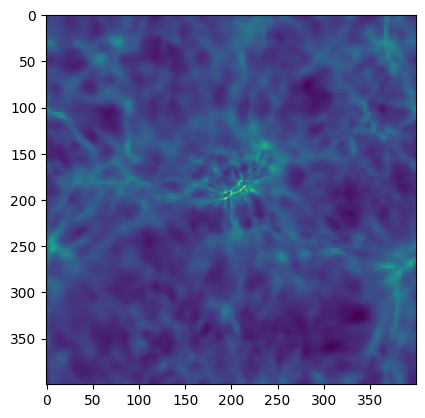

In [7]:
plt.imshow(np.log10(vals[:, :, 200]))

applying operations by-chunk during grid generation (beware units!!)

In [11]:
vals = tag.to_array(
    ("gas", "density"),
    ops=[
        np.log10,
    ],
)
vals[0:10, 0, 0]

unyt_array([-26.92235472, -26.92235472], 'g/cm**3')

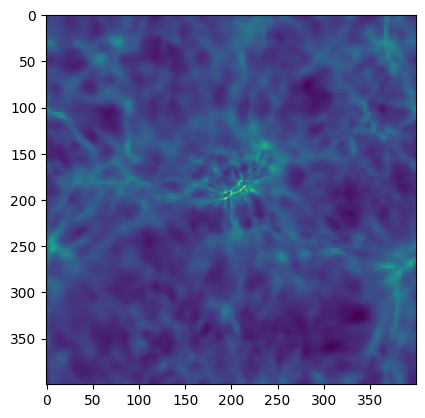

In [12]:
plt.imshow(vals[:, :, 200])

## A single tiled grid, larger-than memory on-disk zarr

In [6]:
tag = YTTiledArbitraryGrid(
    ds.domain_left_edge, ds.domain_right_edge, (2000, 2000, 2000), 100, ds=ds
)

In [7]:
zarr_store = initialize_store("tiled_grid_full.zarr")
zarr_store

<zarr.hierarchy.Group '/'>

create an empty array to fill 

In [9]:
tag.dims, tag.chunks

((2000, 2000, 2000), (100, 100, 100))

In [11]:
zarr_field = zarr_store.empty("gas_density", shape=tag.dims, chunks=tag.chunks)

In [12]:
zarr_field

<zarr.core.Array '/gas_density' (2000, 2000, 2000) float64>

In [14]:
_ = tag.to_array(
    ("gas", "density"),
    full_domain=zarr_field,
    ops=[
        np.log10,
    ],
)

In [15]:
zarr_field.info

Name,/gas_density
Type,zarr.core.Array
Data type,float64
Shape,"(2000, 2000, 2000)"
Chunk shape,"(100, 100, 100)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,64000000000 (59.6G)
No. bytes stored,1169123997 (1.1G)


note directory layout

In [16]:
os.listdir(os.path.join(zarr_store.store.path, "gas_density"))[:10]

['15.17.8',
 '16.10.16',
 '5.8.10',
 '3.16.4',
 '8.10.11',
 '0.5.11',
 '10.11.17',
 '4.7.0',
 '5.13.7',
 '15.16.12']

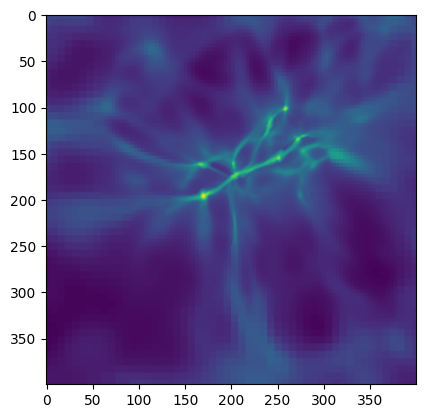

In [18]:
plt.imshow(zarr_field[800:1200, 800:1200, 1000])

## a yt image pryamid

In [4]:
from yt_experiments.tiled_grid import YTArbitraryGridPyramid

In [5]:
?YTArbitraryGridPyramid

Init signature:
YTArbitraryGridPyramid(
    left_edge,
    right_edge,
    level_dims: [tuple[int, int, int]],
    level_chunks,
    ds: yt.data_objects.static_output.Dataset = None,
    field_parameters=None,
    data_source: Optional[Any] = None,
)
Docstring:      <no docstring>
Init docstring:
Parameters
----------
left_edge
right_edge
level_dims
level_chunks
ds
field_parameters
data_source
File:           ~/src/yt_/yt_dev/yt_experiments/yt_experiments/tiled_grid/tiled_grid.py
Type:           type
Subclasses:     YTArbitraryGridOctPyramid

In [6]:
level_dims = [(res,) * 3 for res in range(1000, 200, -200)]
level_dims

[(1000, 1000, 1000), (800, 800, 800), (600, 600, 600), (400, 400, 400)]

In [7]:
level_chunks = 200

In [8]:
pyr = YTArbitraryGridPyramid(
    ds.domain_left_edge, ds.domain_right_edge, level_dims, level_chunks, ds=ds
)

individual levels are comprised of `YTTiledArbitraryGrid` objects, accessible by indexing the object:

In [9]:
pyr[0]

YTTiledArbitraryGrid with total shape of (1000, 1000, 1000) divided into 125 grids: (5, 5, 5) grids in each dimension.

or indexing the `levels` attribute:

In [11]:
pyr

can write to on-disk zarr with

In [29]:
zarr_store = initialize_store("deeply_nested_pyramid.zarr")

note we will downcast to float32 here by providing a dtype argument. This is because we'll later use this zarr to render in napari utilizing GPU rendering, at which point the values would be downcast anyway, so we might as well save a little space now. 

In [30]:
pyr.to_zarr(
    ("gas", "density"),
    zarr_store,
    zarr_name="density_log10",
    ops=[
        np.log10,
    ],
    dtype=np.float32,  #
)

writing level 0
writing level 1
writing level 2
writing level 3
writing level 4
writing level 5
writing level 6
writing level 7
writing level 8


In [31]:
zarr_store["density_log10"].info

Name,/density_log10
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,9
No. arrays,9
No. groups,0
Arrays,"0, 1, 2, 3, 4, 5, 6, 7, 8"


In [32]:
zarr_store["density_log10"]["0"].info

Name,/density_log10/0
Type,zarr.core.Array
Data type,float32
Shape,"(2000, 2000, 2000)"
Chunk shape,"(200, 200, 200)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,32000000000 (29.8G)
No. bytes stored,618639058 (590.0M)


In [33]:
zarr_store["density_log10"]["1"].info

Name,/density_log10/1
Type,zarr.core.Array
Data type,float32
Shape,"(1800, 1800, 1800)"
Chunk shape,"(200, 200, 200)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,23328000000 (21.7G)
No. bytes stored,544929892 (519.7M)


In [34]:
zarr_store["density_log10"]["4"].info

Name,/density_log10/4
Type,zarr.core.Array
Data type,float32
Shape,"(1200, 1200, 1200)"
Chunk shape,"(200, 200, 200)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,6912000000 (6.4G)
No. bytes stored,318182009 (303.4M)


In [35]:
np.max(zarr_store["density_log10"]["3"]), np.min(zarr_store["density_log10"]["3"])

(-21.862093, -27.702736)

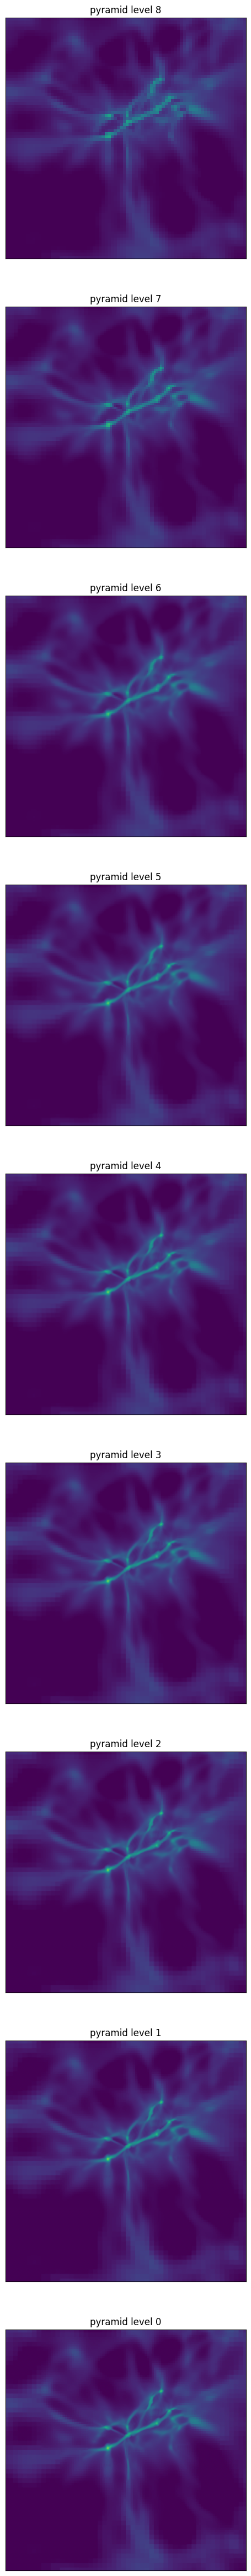

In [40]:
maxlevels = 9

f, axs = plt.subplots(ncols=1, nrows=maxlevels, figsize=(10, 60))
extent = (0, 1, 0, 1)

for ilevel in range(maxlevels - 1, -1, -1):
    vals_3d = zarr_store["density_log10"][str(ilevel)]
    shp = vals_3d.shape
    iplot = (maxlevels - 1) - ilevel
    im = axs[iplot].imshow(
        vals_3d[:, :, int(vals_3d.shape[-1] / 2)], extent=extent, vmin=-27, vmax=-23
    )
    axs[iplot].set_xlim([0.4, 0.6])
    axs[iplot].set_ylim([0.4, 0.6])
    axs[iplot].xaxis.set_visible(False)
    axs[iplot].yaxis.set_visible(False)
    axs[iplot].set_title(f"pyramid level {ilevel}")